<a href="https://colab.research.google.com/github/Prafful9/Image_Captioning_Generator/blob/main/imagecaptioningdeeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.8.0
keras: 2.8.0


In [ ]:
from os import listdir
from pickle import dump
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Embedding
from tensorflow.keras.layers import LSTM, Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import string
import matplotlib.pyplot as plt

In [ ]:
model_Xception=Sequential()
model_Xception.add(Xception(include_top=False,
                            weights='imagenet',
                            pooling='max'))

model_Xception.add(Dropout(0.2))
model_Xception.add(Dense(2048,activation='relu'))
model_Xception.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
Total params: 25,057,832
Trainable params: 25,003,304
Non-trainable params: 54,528
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


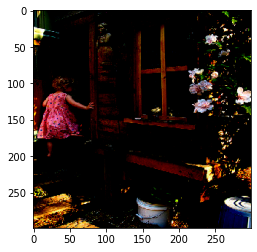

In [ ]:
import matplotlib.pyplot as plt

fil = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
ima = load_img(fil, target_size=(299, 299))
ima = img_to_array(ima)
ima = ima.reshape((ima.shape[0], ima.shape[1], ima.shape[2]))
ima = preprocess_input(ima)
plt.imshow(ima)

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the Xception model
        image = preprocess_input(image)
        # get features
        feature = model_Xception.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
    return features

In [ ]:
# extract features from all images
directory = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_Dataset/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/features.pkl', 'wb'))

Extracted Features: 8101


In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Number of images with their 5 descriptions loaded: %d ' % len(descriptions))

Number of images with their 5 descriptions loaded: 8092 


In [ ]:
import string
 
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        #for i in range(len(desc_list)):
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)


# Making use of the function just created
clean_descriptions(descriptions)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        #for desc in desc_list:   # If you have RAM higher than 16GB uncomment this line
        for desc in desc_list[:2]:  # This will make our program to save only 2 captions per image
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_descriptions(descriptions, '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/descriptions.txt')

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [ ]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [ ]:
from keras.preprocessing.text import Tokenizer

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)  #Default 256
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)    #Default 256
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(128)(se2)     #Default 256
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(128, activation='relu')(decoder1)      #Default 256
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 5200
Description Length: 17


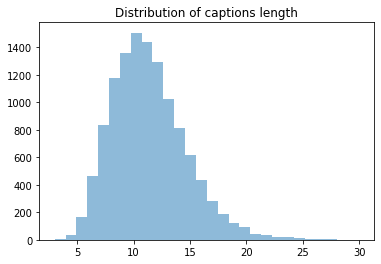

In [ ]:
from pickle import load

# load training dataset (6K)
filename = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/features.pkl', train)
#train_features = load(open('./features.pkl', 'rb'))
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
#max_length = max_length(train_descriptions)
max_length=17
print('Description Length: %d' % max_length)

lengths=[]
lines = to_lines(train_descriptions)
for d in lines:
    lengths.append(len(d.split())) 
    
plt.hist(lengths, bins=28, alpha=0.5)
plt.title('Distribution of captions length')
plt.show()

# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [ ]:
# load test set
filename = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/Flickr_8k.devImages.txt'
dev = load_set(filename)
print('Dataset: %d' % len(dev))
# descriptions
dev_descriptions = load_clean_descriptions('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/descriptions.txt', dev)
print('Descriptions: test=%d' % len(dev_descriptions))
# photo features
dev_features = load_photo_features('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/features.pkl', dev)
print('Photos: test=%d' % len(dev_features))
# prepare sequences
X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions, dev_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=([X1dev, X2dev], ydev))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 128)      665600      ['input_3[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load test set
filename = '/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_text/tokenizer.pkl', 'wb'))

In [ ]:
from keras.models import load_model

# load the model
filename = '/content/model-ep020-loss2.880-val_loss4.737.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.395658
BLEU-2: 0.196128
BLEU-3: 0.139488
BLEU-4: 0.065167


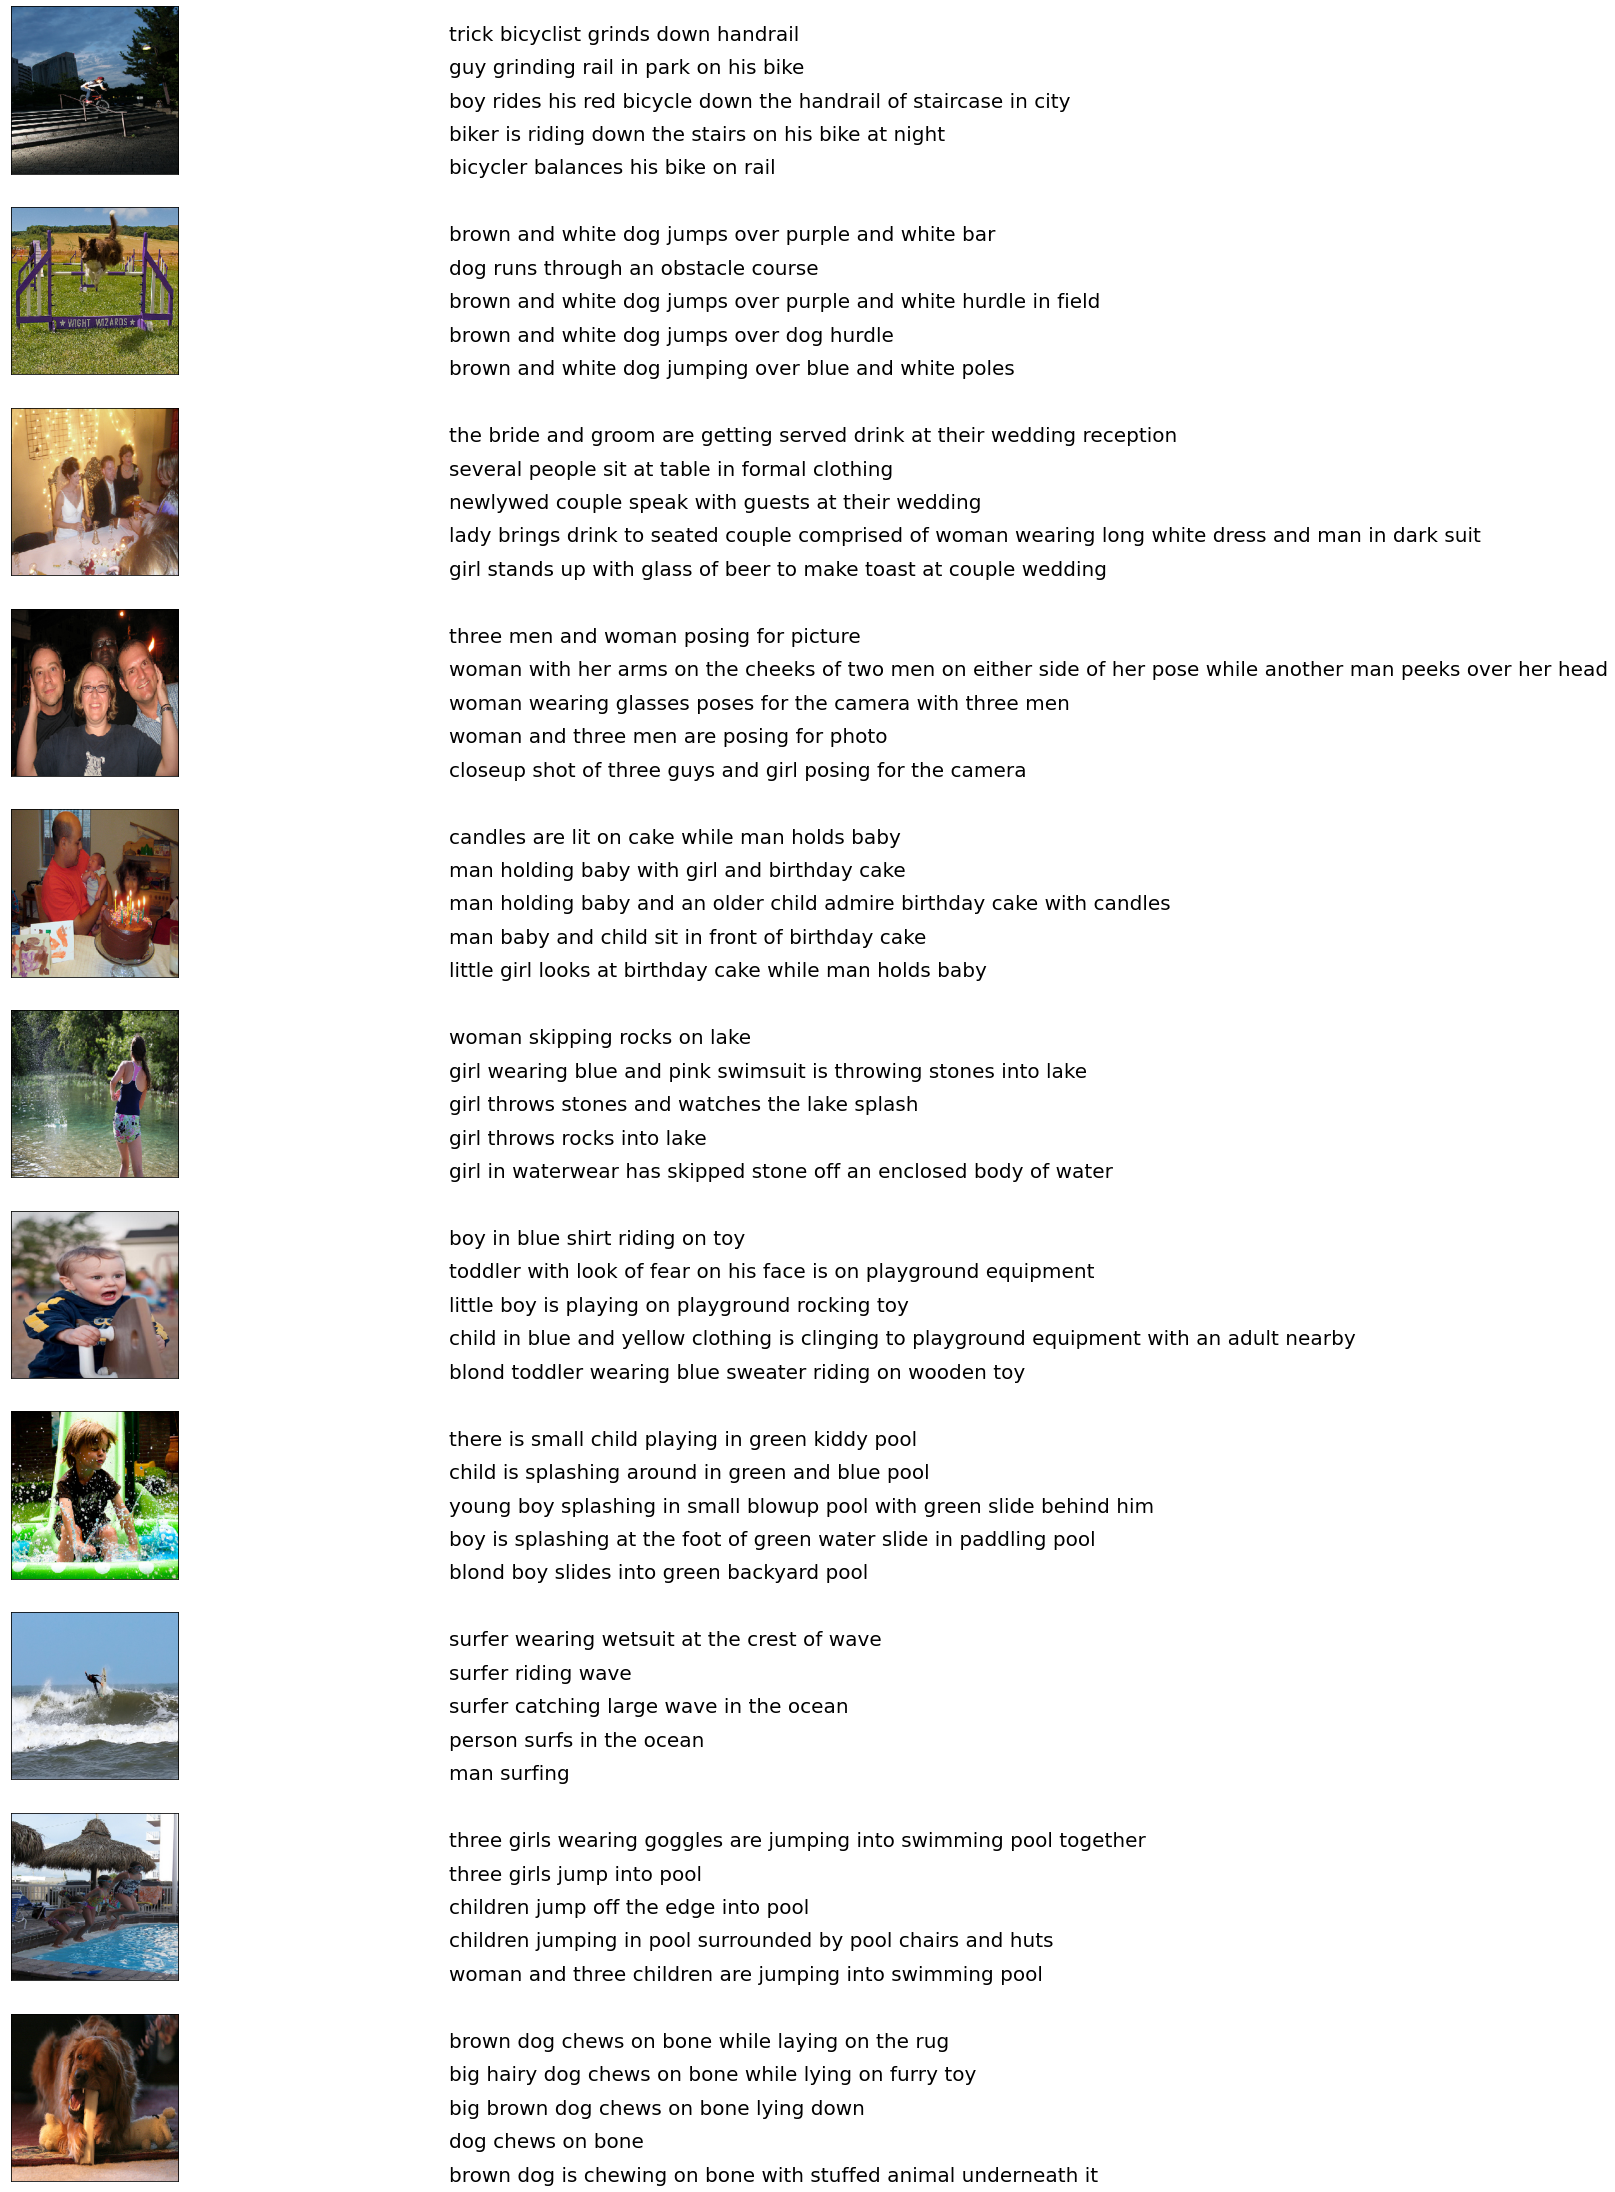

In [ ]:
from keras.preprocessing.image import load_img

dir_descriptions = "/content/drive/MyDrive/flickr8k_Dataset/Flickr8k.token.txt"
dir_imgs = "/content/drive/MyDrive/flickr8k_Dataset/Flickr8k_Dataset/Flicker8k_Dataset"
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(20,40))
for img in listdir(dir_imgs)[:11]:
    filename = dir_imgs + '/' + img
    captions = descriptions[img.split('.')[0]]
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(11, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(11, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()